In [1]:
# Importing the dpendancies

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [2]:
# Read the data

data = pd.read_csv('/home/ali/Cellula/KNN/first inten project.csv')

In [3]:
data.shape

(36285, 17)

In [4]:
# Printing the first 5 rows of the data

data.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [5]:
# Replacing spaces in column names with _

data.columns = [col.replace(" ", "_") for col in data.columns]
data.columns = [col.replace("-", "_") for col in data.columns]

In [6]:
# Checking for null data

data.isnull().sum()

Booking_ID                  0
number_of_adults            0
number_of_children          0
number_of_weekend_nights    0
number_of_week_nights       0
type_of_meal                0
car_parking_space           0
room_type                   0
lead_time                   0
market_segment_type         0
repeated                    0
P_C                         0
P_not_C                     0
average_price_              0
special_requests            0
date_of_reservation         0
booking_status              0
dtype: int64

In [7]:
# Printing data information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number_of_adults          36285 non-null  int64  
 2   number_of_children        36285 non-null  int64  
 3   number_of_weekend_nights  36285 non-null  int64  
 4   number_of_week_nights     36285 non-null  int64  
 5   type_of_meal              36285 non-null  object 
 6   car_parking_space         36285 non-null  int64  
 7   room_type                 36285 non-null  object 
 8   lead_time                 36285 non-null  int64  
 9   market_segment_type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P_C                       36285 non-null  int64  
 12  P_not_C                   36285 non-null  int64  
 13  average_price_            36285 non-null  float64
 14  specia

In [8]:
# Dropping some columns

data.drop(columns = ['Booking_ID', 'date_of_reservation'], axis = 1, inplace = True)

<Axes: >

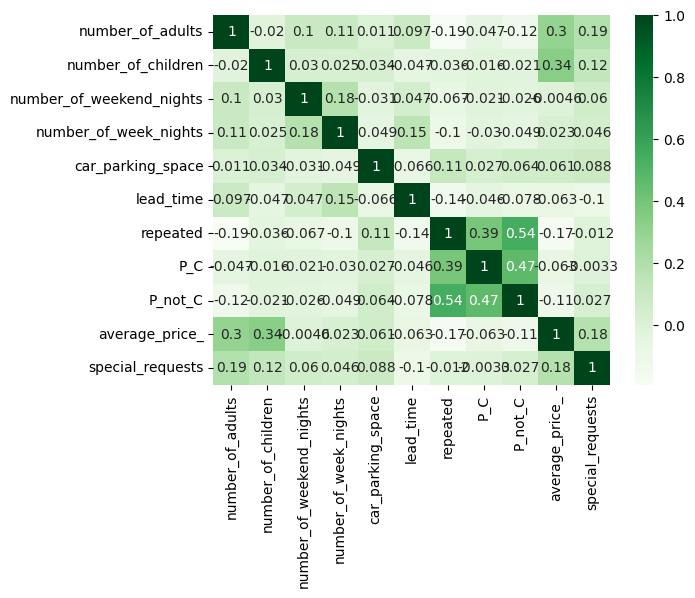

In [9]:
# Checking correlation between features

correlation_matrix = data.drop(columns=['booking_status', 'type_of_meal','room_type', 'market_segment_type'], axis = 1).corr()
sns.heatmap(correlation_matrix, cmap="Greens", annot= True)

In [10]:
Z = data[['number_of_adults', 'number_of_children', 'number_of_weekend_nights', 'number_of_week_nights',
        'car_parking_space', 'lead_time', 'repeated', 'P_C', 'P_not_C', 'average_price_', 'special_requests']]
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = Z.columns
vif_data["VIF"] = [variance_inflation_factor(Z.values, i) for i in range(Z.shape[1])]

print("\nVariance Inflation Factor (VIF):\n", vif_data)


Variance Inflation Factor (VIF):
                      Feature        VIF
0           number_of_adults  11.390941
1         number_of_children   1.228988
2   number_of_weekend_nights   1.934481
3      number_of_week_nights   3.469714
4          car_parking_space   1.062180
5                  lead_time   2.059511
6                   repeated   1.504436
7                        P_C   1.333471
8                    P_not_C   1.601607
9             average_price_   9.741627
10          special_requests   1.768242


In [11]:
# turnning all features into numerical features

dummies_1 = pd.get_dummies(data['type_of_meal'], dtype = int)
dummies_2 = pd.get_dummies(data['room_type'], dtype = int)
dummies_3 = pd.get_dummies(data['market_segment_type'], dtype = int)
data = pd.concat([data.drop(['type_of_meal','room_type','market_segment_type'], axis=1), dummies_1, dummies_2, dummies_3], axis=1)

In [12]:
labelencoder = LabelEncoder()
data['booking_status']= labelencoder.fit_transform(data['booking_status']) 

In [13]:
# dropping duplicate data

print(sum(data.duplicated()))
data.drop_duplicates(inplace = True)

10747


In [14]:
data.shape

(25538, 28)

In [15]:
# Function to remove outliers

def remove_outliers(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for the data
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = None
    no_of_outliers = sum((df[column_name] < lower_bound) | (df[column_name] > upper_bound))
    while (no_of_outliers > 0):
        # Filter out the outliers 
        filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
        Q1 = filtered_df[column_name].quantile(0.25)
        Q3 = filtered_df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        print("number of outliers is : {} for {} ".format(no_of_outliers, column_name))
        no_of_outliers = sum((filtered_df[column_name] < lower_bound) | (filtered_df[column_name] > upper_bound))
    return filtered_df

In [ ]:
# Removing oultiers from certain features

features = ['number_of_weekend_nights', 'number_of_week_nights','lead_time', 'repeated', 'average_price_', 'special_requests']

for feature in features:
    data = remove_outliers(data, feature)

number of outliers is : 21 for number_of_weekend_nights 
number of outliers is : 279 for number_of_week_nights 
number of outliers is : 825 for lead_time 
number of outliers is : 289 for lead_time 
number of outliers is : 114 for lead_time 
number of outliers is : 46 for lead_time 
number of outliers is : 81 for lead_time 
number of outliers is : 44 for lead_time 
number of outliers is : 816 for repeated 
number of outliers is : 807 for average_price_ 
number of outliers is : 113 for average_price_ 
number of outliers is : 33 for average_price_ 
number of outliers is : 565 for special_requests 


In [17]:
data.shape

(21505, 28)

In [18]:
# Forming the data

X = data.drop(columns = ['booking_status'], axis = 1)
Y = data['booking_status']

In [19]:
# Data Standrization

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [20]:
# Forming train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

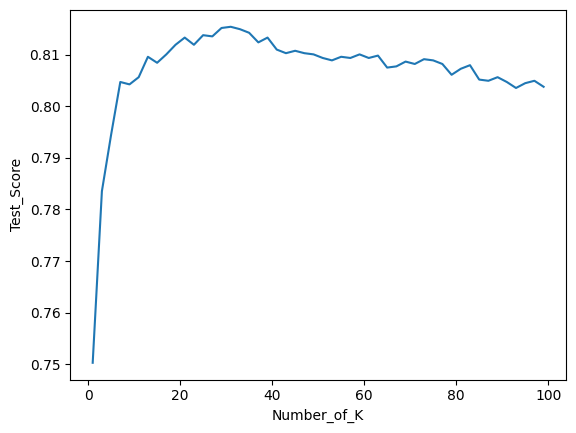

In [21]:
# KNN Model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

K = []
test_score = []

for k in range(1, 100, 2):

    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, Y_train)
    y_preds = model.predict(X_test)
    K.append(k)
    test_score.append(accuracy_score(Y_test, y_preds))
    K, test_score
    
plt.plot(K, test_score)
plt.xlabel("Number_of_K")
plt.ylabel("Test_Score")
plt.show()


In [22]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

CM_KNN = confusion_matrix(Y_test, model.predict(X_test))
print(CM_KNN)

[[ 586  613]
 [ 231 2871]]


In [23]:
# Classification report

CR_KNN = classification_report(Y_test, model.predict(X_test))
print(CR_KNN)

              precision    recall  f1-score   support

           0       0.72      0.49      0.58      1199
           1       0.82      0.93      0.87      3102

    accuracy                           0.80      4301
   macro avg       0.77      0.71      0.73      4301
weighted avg       0.79      0.80      0.79      4301



In [24]:
# Logistic model

from sklearn.linear_model import LogisticRegression

Logistic_model = LogisticRegression()
Logistic_model.fit(X_train, Y_train)
y_preds_logistic = Logistic_model.predict(X_test)

In [25]:
# Confusion matrix

CM_logistic = confusion_matrix(Y_test, y_preds_logistic)
print(CM_logistic)

[[ 609  590]
 [ 274 2828]]


In [26]:
# Classification report

CR_logistic = classification_report(Y_test, y_preds_logistic)
print(CR_logistic)

              precision    recall  f1-score   support

           0       0.69      0.51      0.59      1199
           1       0.83      0.91      0.87      3102

    accuracy                           0.80      4301
   macro avg       0.76      0.71      0.73      4301
weighted avg       0.79      0.80      0.79      4301



In [27]:
# XGB Classifier model

from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(X_train, Y_train)
y_preds_XGB = XGB_model.predict(X_test)

In [28]:
# Confusion matrix

CM_XGB = confusion_matrix(Y_test, y_preds_XGB)
print(CM_XGB)

[[ 758  441]
 [ 253 2849]]


In [29]:
# Classification report

CR_XGB = classification_report(Y_test, y_preds_XGB)
print(CR_XGB)

              precision    recall  f1-score   support

           0       0.75      0.63      0.69      1199
           1       0.87      0.92      0.89      3102

    accuracy                           0.84      4301
   macro avg       0.81      0.78      0.79      4301
weighted avg       0.83      0.84      0.83      4301

